In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import glob
from Bio import Phylo, SeqIO
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from scipy import stats

In [3]:
import matplotlib
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['ytick.labelsize'] = 16
matplotlib.rcParams['axes.labelsize'] = 16
matplotlib.rcParams['axes.titlesize'] = 16

matplotlib.rcParams['axes.grid'] = True
matplotlib.rcParams['grid.color'] = '0.5'
matplotlib.rcParams['grid.linewidth'] = '0.5'

matplotlib.rcParams['axes.edgecolor'] = '0.25'
matplotlib.rcParams['xtick.color'] = '0'
matplotlib.rcParams['ytick.color'] = '0'

matplotlib.rcParams['xtick.major.width'] = 1
matplotlib.rcParams['ytick.major.width'] = 1
matplotlib.rcParams['ytick.major.size'] = 5
matplotlib.rcParams['xtick.major.size'] = 5
matplotlib.rcParams['axes.spines.right'] = True
matplotlib.rcParams['axes.spines.left'] = True
matplotlib.rcParams['axes.spines.top'] = True
matplotlib.rcParams['axes.spines.bottom'] = True

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'Helvetica'
matplotlib.rcParams['font.weight']='normal'
matplotlib.rcParams['axes.axisbelow'] = True

# Read in dataframe containing monophyly information

In [90]:
# monophyly_df = pd.read_csv('../Data/OMA_group_data/eukaryotes/tree_monophyly.csv', index_col='Group_id')
monophyly_df = pd.read_csv('../Data/Tria_et_al_data/eukaryotes/tree_monophyly.csv', index_col='Group_id')
print(monophyly_df.shape)
monophyly_df.head(n=10)

(400, 9)


,monophyletic_clade,other_clade,root_bl,monophyletic_total_bl,other_total_bl,total_tree_bl,total_n,monophyletic_n,other_n
Group_id,,,,,,,,,
KOG2115,IntNode_3,IntNode_4,2.16480,11.65634,8.83701,22.65815,31.0,17.0,14.0
KOG0266,IntNode_13,IntNode_10,1.18180,5.44034,15.87080,22.49294,31.0,17.0,14.0
KOG2609,IntNode_3,IntNode_16,1.27520,18.11668,7.23651,26.62839,31.0,17.0,14.0
KOG0800,IntNode_11,IntNode_10,1.28320,8.93623,20.26973,30.48916,31.0,17.0,14.0
KOG1506,IntNode_13,IntNode_6,0.38028,2.31323,2.37654,5.07005,31.0,17.0,14.0
KOG4205,IntNode_13,IntNode_5,0.44705,10.04185,12.59999,23.08889,31.0,17.0,14.0
KOG3675,IntNode_13,IntNode_12,0.66670,5.51231,5.69018,11.86919,31.0,17.0,14.0
KOG4103,IntNode_3,IntNode_16,1.46710,7.14283,6.45482,15.06475,31.0,17.0,14.0
KOG2496,IntNode_12,IntNode_16,1.16810,11.33443,8.63006,21.13259,31.0,17.0,14.0


# Testing algorithm accuracies on full datasets

In [91]:
# trees_dir = '../Data/OMA_group_data/eukaryotes/processed_OMA_trees/*treefile.RootedNoZero.MPAJH'
# trees_dir = '../Data/OMA_group_data/eukaryotes/processed_OMA_trees/*Terms.Rooted.MPAJH'
# trees_dir = '../Data/OMA_group_data/eukaryotes/pruned_OMA_trees/*frac0.05*treefile.RootedNoZero.MPAJH'
# trees_dir = '../Data/OMA_group_data/eukaryotes/pruned_OMA_trees/*frac0.5*treefile.RootedNoZero.MPAJH'
# trees_dir = '../Data/OMA_group_data/eukaryotes/pruned_OMA_trees/*frac0.95*treefile.RootedNoZero.MPAJH'
# trees_dir = '../Data/Tria_et_al_data/eukaryotes/processed_trees/*treefile.RootedNoZero.MPAJH'
trees_dir = '../Data/Tria_et_al_data/eukaryotes/pruned_trees/*frac0.9*treefile.RootedNoZero.MPAJH'


# methods = ['.MPAJH','.MinVarAJH', '.MADAJH']
methods = ['.MPAJH',\
           '.MinVarAJH', '.MinVarGSCAJH', '.MinVarGSCnAJH', '.MinVarHHAJH',\
          '.MADAJH', '.MADweightAJH', '.MADweightNormedAJH']
# methods = ['.MPAJH',\
#            '.MinVarAJH', '.MinVarGSCAJH', '.MinVarGSCnAJH', '.MinVarHHAJH']

for method in methods:
    monophyly_df['{}_success'.format(method)] = np.nan

trees_tested = []

for tree_loc in glob.glob(trees_dir)[:]:
#     print(tree_loc)
    group = tree_loc.split('/')[-1].split('.')[0]
    if type(monophyly_df.loc[group]['monophyletic_clade']) != str:
        continue
    for method in methods:
        my_tree = Phylo.read(tree_loc.replace('.MPAJH', method), 'newick', rooted=True)
        internals = [i.name for i in my_tree.get_nonterminals()]
        assert monophyly_df.loc[group]['monophyletic_clade'] in internals
        assert monophyly_df.loc[group]['other_clade'] in internals
        if monophyly_df.loc[group]['monophyletic_clade'] in [clade.name for clade in my_tree.root.clades] \
        and monophyly_df.loc[group]['other_clade'] in [clade.name for clade in my_tree.root.clades]:
            monophyly_df.set_value(group, '{}_success'.format(method), 1)
        else:
            monophyly_df.set_value(group, '{}_success'.format(method), 0)
    trees_tested.append(tree_loc)

In [92]:
for method in methods:
    print(method, '\t', monophyly_df['{}_success'.format(method)].sum())

.MPAJH 	 236.0
.MinVarAJH 	 211.0
.MinVarGSCAJH 	 212.0
.MinVarGSCnAJH 	 220.0
.MinVarHHAJH 	 217.0
.MADAJH 	 201.0
.MADweightAJH 	 220.0
.MADweightNormedAJH 	 214.0


In [ ]:
monophyly_df[monophyly_df['monophyletic_clade'].isnull()==False].shape

In [ ]:
print(len(trees_tested))

In [ ]:
monophyly_df.head()

# Making (probably temporary) figures

In [4]:
# monophyly_df = pd.read_csv('../Data/OMA_group_data/eukaryotes/tree_monophyly.csv', index_col='Group_id')
monophyly_df = pd.read_csv('../Data/Tria_et_al_data/eukaryotes/tree_monophyly.csv', index_col='Group_id')
print(monophyly_df.shape)
possible_successes = monophyly_df[monophyly_df['monophyletic_clade'].isnull()==False].shape[0]
print(possible_successes)
monophyly_df.head(n=10)

(400, 9)
371


,monophyletic_clade,other_clade,root_bl,monophyletic_total_bl,other_total_bl,total_tree_bl,total_n,monophyletic_n,other_n
Group_id,,,,,,,,,
KOG2115,IntNode_3,IntNode_4,2.16480,11.65634,8.83701,22.65815,31.0,17.0,14.0
KOG0266,IntNode_13,IntNode_10,1.18180,5.44034,15.87080,22.49294,31.0,17.0,14.0
KOG2609,IntNode_3,IntNode_16,1.27520,18.11668,7.23651,26.62839,31.0,17.0,14.0
KOG0800,IntNode_11,IntNode_10,1.28320,8.93623,20.26973,30.48916,31.0,17.0,14.0
KOG1506,IntNode_13,IntNode_6,0.38028,2.31323,2.37654,5.07005,31.0,17.0,14.0
KOG4205,IntNode_13,IntNode_5,0.44705,10.04185,12.59999,23.08889,31.0,17.0,14.0
KOG3675,IntNode_13,IntNode_12,0.66670,5.51231,5.69018,11.86919,31.0,17.0,14.0
KOG4103,IntNode_3,IntNode_16,1.46710,7.14283,6.45482,15.06475,31.0,17.0,14.0
KOG2496,IntNode_12,IntNode_16,1.16810,11.33443,8.63006,21.13259,31.0,17.0,14.0


In [5]:
# trees_dir = '../Data/OMA_group_data/eukaryotes/processed_OMA_trees/*treefile.RootedNoZero.MPAJH'
# trees_dir = '../Data/OMA_group_data/eukaryotes/processed_OMA_trees/*Terms.Rooted.MPAJH'
results_dict = {}
for trees_dir in ['../Data/Tria_et_al_data/eukaryotes/pruned_trees/*frac0.1*treefile.RootedNoZero.MPAJH',\
                  '../Data/Tria_et_al_data/eukaryotes/pruned_trees/*frac0.5*treefile.RootedNoZero.MPAJH',\
                  '../Data/Tria_et_al_data/eukaryotes/pruned_trees/*frac0.9*treefile.RootedNoZero.MPAJH']:
# for trees_dir in ['../Data/OMA_group_data/eukaryotes/pruned_OMA_trees/*frac0.05*treefile.RootedNoZero.MPAJH',\
#                   '../Data/OMA_group_data/eukaryotes/pruned_OMA_trees/*frac0.5*treefile.RootedNoZero.MPAJH',\
#                   '../Data/OMA_group_data/eukaryotes/pruned_OMA_trees/*frac0.95*treefile.RootedNoZero.MPAJH']:
    
    fraction = trees_dir[trees_dir.find('frac'):trees_dir.find('frac')+7]
    methods = ['.MPAJH',\
               '.MinVarAJH', '.MinVarGSCAJH', '.MinVarGSCnAJH', '.MinVarHHAJH',\
              '.MADAJH', '.MADweightAJH', '.MADweightNormedAJH']
    for method in methods:
        monophyly_df['{}_success'.format(method)] = np.nan

    trees_tested = []

    for tree_loc in glob.glob(trees_dir)[:]:
    #     print(tree_loc)
        group = tree_loc.split('/')[-1].split('.')[0]
        if type(monophyly_df.loc[group]['monophyletic_clade']) != str:
            continue
        for method in methods:
            my_tree = Phylo.read(tree_loc.replace('.MPAJH', method), 'newick', rooted=True)
            internals = [i.name for i in my_tree.get_nonterminals()]
            assert monophyly_df.loc[group]['monophyletic_clade'] in internals
            assert monophyly_df.loc[group]['other_clade'] in internals
            if monophyly_df.loc[group]['monophyletic_clade'] in [clade.name for clade in my_tree.root.clades] \
            and monophyly_df.loc[group]['other_clade'] in [clade.name for clade in my_tree.root.clades]:
                monophyly_df.set_value(group, '{}_success'.format(method), 1)
            else:
                monophyly_df.set_value(group, '{}_success'.format(method), 0)
        trees_tested.append(tree_loc)
    results_list = []
    for method in methods:
        results_list.append(monophyly_df['{}_success'.format(method)].sum()/possible_successes)
    results_dict[fraction] = results_list

In [6]:
results_dict

{'frac0.1': [0.6253369272237197,
  0.65498652291105119,
  0.60377358490566035,
  0.60916442048517516,
  0.63342318059299196,
  0.66576819407008081,
  0.64150943396226412,
  0.64150943396226412],
 'frac0.5': [0.64150943396226412,
  0.69272237196765496,
  0.61185983827493262,
  0.63611859838274931,
  0.65768194070080865,
  0.72506738544474392,
  0.67115902964959573,
  0.69002695417789761],
 'frac0.9': [0.63611859838274931,
  0.56873315363881405,
  0.5714285714285714,
  0.59299191374663074,
  0.58490566037735847,
  0.5417789757412399,
  0.59299191374663074,
  0.5768194070080862]}

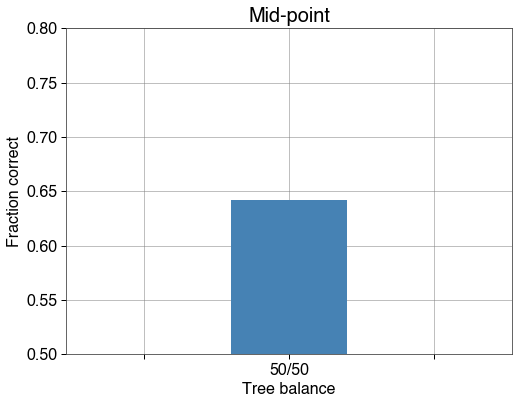

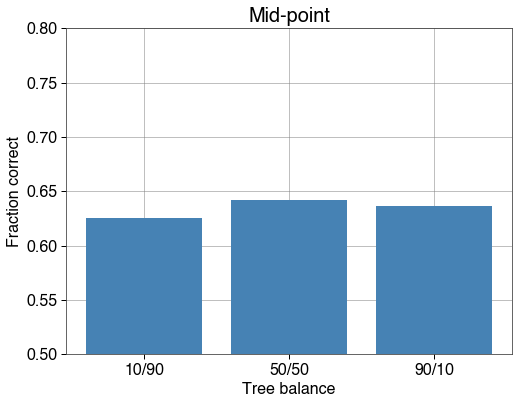

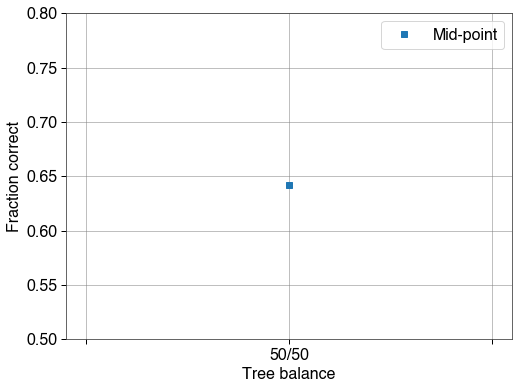

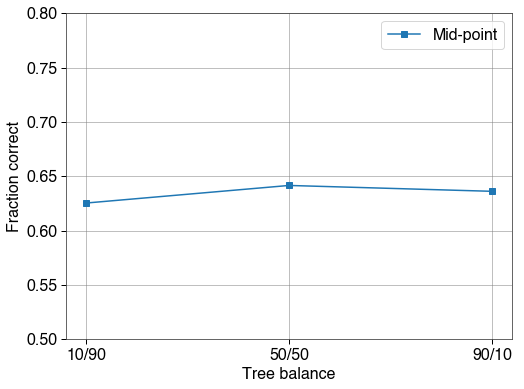

In [10]:
to_plot = [0, results_dict['frac0.5'][0], 0]

fig, ax = plt.subplots(figsize=(8,6))
ax.bar(np.arange(len(to_plot)), to_plot, color='steelblue')
ax.set_xticks(np.arange(len(to_plot)))
ax.set_xticklabels(['', '50/50', ''])
ax.set_ylabel('Fraction correct')
ax.set_xlabel('Tree balance')
ax.set_ylim(0.5, 0.8)
ax.set_title('Mid-point', fontsize=20)
plt.savefig('../TriaJustMP.png', bbox_inches='tight')



to_plot = [results_dict['frac0.1'][0], results_dict['frac0.5'][0], results_dict['frac0.9'][0]]
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(np.arange(len(to_plot)), to_plot, color='steelblue')
ax.set_xticks(np.arange(len(to_plot)))
ax.set_xticklabels(['10/90', '50/50', '90/10'])
ax.set_ylabel('Fraction correct')
ax.set_xlabel('Tree balance')
ax.set_ylim(0.5, 0.8)
ax.set_title('Mid-point', fontsize=20)
plt.savefig('../TriaMPBars.png', bbox_inches='tight')



to_plot = [0, results_dict['frac0.5'][0],0]
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(np.arange(len(to_plot)), to_plot, label='Mid-point', marker='s', linestyle='')
ax.set_xticks(np.arange(len(to_plot)))
ax.set_xticklabels(['', '50/50', ''])
ax.set_ylabel('Fraction correct')
ax.set_xlabel('Tree balance')
ax.set_ylim(0.5, 0.8)
ax.legend(fontsize=16)
plt.savefig('../TriaMPLineSingle.png', bbox_inches='tight')

to_plot = [results_dict['frac0.1'][0], results_dict['frac0.5'][0], results_dict['frac0.9'][0]]
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(np.arange(len(to_plot)), to_plot, label='Mid-point', marker='s')
ax.set_xticks(np.arange(len(to_plot)))
ax.set_xticklabels(['10/90', '50/50', '90/10'])
ax.set_ylabel('Fraction correct')
ax.set_xlabel('Tree balance')
ax.set_ylim(0.5, 0.8)
ax.legend(fontsize=16)
plt.savefig('../TriaMPLine.png', bbox_inches='tight')

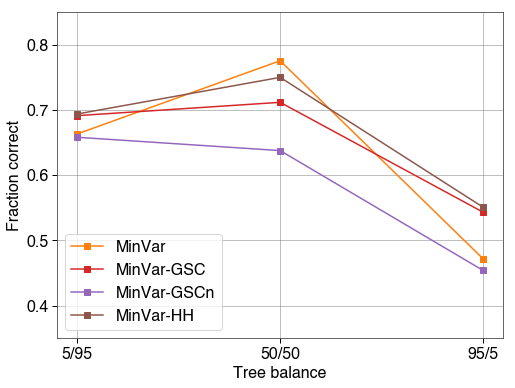

In [169]:
to_plot_MinVar = [results_dict['frac0.0'][1], results_dict['frac0.5'][1], results_dict['frac0.9'][1]]
to_plot_MinVar_a = [results_dict['frac0.0'][2], results_dict['frac0.5'][2], results_dict['frac0.9'][2]]
to_plot_MinVar_b = [results_dict['frac0.0'][3], results_dict['frac0.5'][3], results_dict['frac0.9'][3]]
to_plot_MinVar_c = [results_dict['frac0.0'][4], results_dict['frac0.5'][4], results_dict['frac0.9'][4]]

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']



fig, ax = plt.subplots(figsize=(8,6))
next(ax._get_lines.prop_cycler)
ax.plot(np.arange(len(to_plot_MinVar)), to_plot_MinVar, marker='s', label='MinVar')
next(ax._get_lines.prop_cycler)
ax.plot(np.arange(len(to_plot_MinVar)), to_plot_MinVar_a, marker='s', label='MinVar-GSC')
ax.plot(np.arange(len(to_plot_MinVar)), to_plot_MinVar_b, marker='s', label='MinVar-GSCn')
ax.plot(np.arange(len(to_plot_MinVar)), to_plot_MinVar_c, marker='s', label='MinVar-HH')
ax.set_xticks(np.arange(len(to_plot)))
ax.set_xticklabels(['5/95', '50/50', '95/5'])
ax.set_ylabel('Fraction correct')
ax.set_xlabel('Tree balance')
ax.set_ylim(0.35, 0.85)
ax.legend(fontsize=16)
plt.savefig('../OMAMinVarAll.png', bbox_inches='tight')

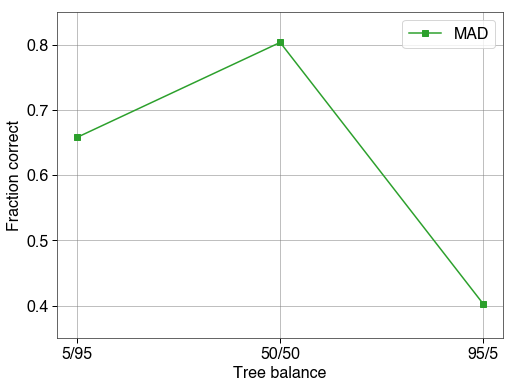

In [173]:
to_plot_MAD = [results_dict['frac0.0'][5], results_dict['frac0.5'][5], results_dict['frac0.9'][5]]
to_plot_MAD_a = [results_dict['frac0.0'][6], results_dict['frac0.5'][6], results_dict['frac0.9'][6]]
to_plot_MAD_b = [results_dict['frac0.0'][7], results_dict['frac0.5'][7], results_dict['frac0.9'][7]]

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, ax = plt.subplots(figsize=(8,6))
next(ax._get_lines.prop_cycler)
next(ax._get_lines.prop_cycler)
ax.plot(np.arange(len(to_plot_MAD)), to_plot_MAD, marker='s', label='MAD')
next(ax._get_lines.prop_cycler)
# ax.plot(np.arange(len(to_plot_MAD)), to_plot_MAD_a, marker='s', label='MAD-AJH')
# ax.plot(np.arange(len(to_plot_MAD)), to_plot_MAD_b, marker='s', label='MAD-AJHn')
ax.set_xticks(np.arange(len(to_plot)))
ax.set_xticklabels(['5/95', '50/50', '95/5'])
ax.set_ylabel('Fraction correct')
ax.set_xlabel('Tree balance')
ax.set_ylim(0.35, 0.85)
ax.legend(fontsize=16)
plt.savefig('../OMAMAD.png', bbox_inches='tight')

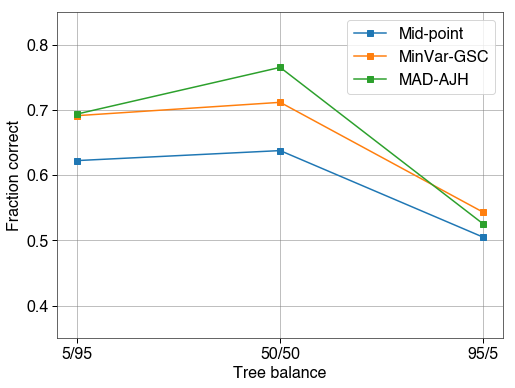

In [174]:
to_plot_mp = [results_dict['frac0.0'][0], results_dict['frac0.5'][0], results_dict['frac0.9'][0]]
to_plot_MinVar = [results_dict['frac0.0'][2], results_dict['frac0.5'][2], results_dict['frac0.9'][2]]
to_plot_MAD = [results_dict['frac0.0'][6], results_dict['frac0.5'][6], results_dict['frac0.9'][6]]

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(np.arange(len(to_plot_mp)), to_plot_mp, marker='s', label='Mid-point')
ax.plot(np.arange(len(to_plot_MinVar)), to_plot_MinVar, marker='s', label='MinVar-GSC')
ax.plot(np.arange(len(to_plot_MAD)), to_plot_MAD, marker='s', label='MAD-AJH')

ax.set_xticks(np.arange(len(to_plot)))
ax.set_xticklabels(['5/95', '50/50', '95/5'])
ax.set_ylabel('Fraction correct')
ax.set_xlabel('Tree balance')
ax.set_ylim(0.35, 0.85)
ax.legend(fontsize=16)
plt.savefig('../Best.png', bbox_inches='tight')

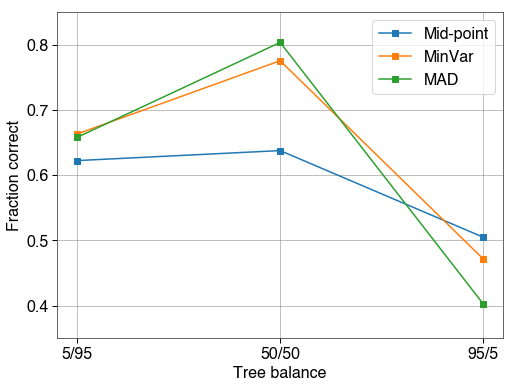

In [159]:
to_plot_mp = [results_dict['frac0.0'][0], results_dict['frac0.5'][0], results_dict['frac0.9'][0]]
to_plot_MinVar = [results_dict['frac0.0'][1], results_dict['frac0.5'][1], results_dict['frac0.9'][1]]
to_plot_MAD = [results_dict['frac0.0'][5], results_dict['frac0.5'][5], results_dict['frac0.9'][5]]




fig, ax = plt.subplots(figsize=(8,6))
ax.plot(np.arange(len(to_plot_mp)), to_plot_mp, marker='s', label='Mid-point')
ax.plot(np.arange(len(to_plot_MinVar)), to_plot_MinVar, marker='s', label='MinVar')
ax.plot(np.arange(len(to_plot_MAD)), to_plot_MAD, marker='s', label='MAD')
ax.set_xticks(np.arange(len(to_plot)))
ax.set_xticklabels(['5/95', '50/50', '95/5'])
ax.set_ylabel('Fraction correct')
ax.set_xlabel('Tree balance')
ax.set_ylim(0.35, 0.85)
ax.legend(fontsize=16)
plt.savefig('../OMABasicLine.png', bbox_inches='tight')

In [ ]:
to_plot_mp = [results_dict['frac0.0'][0], results_dict['frac0.5'][0], results_dict['frac0.9'][0]]
to_plot_MinVar = [results_dict['frac0.0'][1], results_dict['frac0.5'][1], results_dict['frac0.9'][1]]
to_plot_MAD = [results_dict['frac0.0'][5], results_dict['frac0.5'][5], results_dict['frac0.9'][5]]




fig, ax = plt.subplots(figsize=(8,6))
ax.plot(np.arange(len(to_plot_mp)), to_plot_mp, marker='s', label='Mid-point')
ax.plot(np.arange(len(to_plot_MinVar)), to_plot_MinVar, marker='s', label='MinVar')
ax.plot(np.arange(len(to_plot_MAD)), to_plot_MAD, marker='s', label='MAD')
ax.set_xticks(np.arange(len(to_plot)))
ax.set_xticklabels(['5/95', '50/50', '95/5'])
ax.set_ylabel('Fraction correct')
ax.set_xlabel('Tree balance')
ax.set_ylim(0.35, 0.85)
ax.legend(fontsize=16)
plt.savefig('../OMABasicLine.png', bbox_inches='tight')

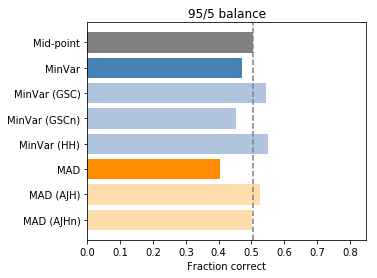

In [86]:
to_plot = results_dict['../Data/OMA_group_data/eukaryotes/pruned_OMA_trees/*frac0.95*treefile.RootedNoZero.MPAJH']
# to_plot = results_dict['../Data/Tria_et_al_data/eukaryotes/pruned_trees/*frac0.1*treefile.RootedNoZero.MPAJH']
colors = ['gray', 'steelblue', 'lightsteelblue', 'lightsteelblue', 'lightsteelblue',\
          'darkorange', 'navajowhite', 'navajowhite']

fig, ax = plt.subplots(figsize=(5,4))
ax.barh(np.arange(len(to_plot)), to_plot, color=colors)
ax.set_ylim(ax.get_ylim()[::-1])
ax.axvline(to_plot[0], color='gray', linestyle='--')
ax.set_yticklabels(['', 'Mid-point', 'MinVar', 'MinVar (GSC)', 'MinVar (GSCn)', 'MinVar (HH)',\
                   'MAD', 'MAD (AJH)', 'MAD (AJHn)'])
ax.set_xlabel('Fraction correct')
ax.set_xlim(0, 0.85)
ax.set_title('95/5 balance')
# plt.savefig('../OMA0.95accuracy.png', bbox_inches='tight')

# This only makes sense for non-pruned trees. 

But is a test of whether there is a statistical difference in the trees that one method gets right and another method gets wrong. I'm generally interested in whether methods are more robust to tree imbalance so the "statistical difference in the trees" that I'm caring about are essentialy the balance in terms of the number of taxa in the two monophyletic groups or the relative branch length of these two groups. 

In [ ]:
testy = monophyly_df[(monophyly_df['.MADAJH_success']==0) & (monophyly_df['.MPAJH_success']==1)]
# res_a = testy['total_tree_bl']
###Look at branch length. If balanced, these would be 0.5
# res_a = testy['monophyletic_total_bl'] / (testy['total_tree_bl'] - testy['root_bl'])
###Look at taxa number, if balanced these would be 0.5 as well
###My instinct is that this is the most relevant thing to care about
res_a = testy['monophyletic_n'] / testy['total_n']
###Look at branch length per taxa. My instinct is that this is dumb
# res_a = (testy['monophyletic_total_bl']/testy['monophyletic_n']) /((testy['total_tree_bl']-testy['root_bl'])/testy['total_n'])
res_a

In [ ]:
testy = monophyly_df[(monophyly_df['.MADAJH_success']==1) & (monophyly_df['.MPAJH_success']==0)]
# res_b = testy['total_tree_bl']
# res_b = testy['monophyletic_total_bl'] / (testy['total_tree_bl']-testy['root_bl'])
res_b = testy['monophyletic_n'] / testy['total_n']
# res_b = (testy['monophyletic_total_bl']/testy['monophyletic_n']) / ((testy['total_tree_bl']-testy['root_bl'])/testy['total_n'])
res_b

In [ ]:
stats.ranksums(res_a.values, res_b.values),\
    np.median(res_a.values), np.median(res_b.values)

In [ ]:
stats.ranksums(np.abs(0.5-res_a.values), np.abs(0.5-res_b.values)),\
    np.median(np.abs(0.5-res_a.values)), np.median(np.abs(0.5-res_b.values)) 

In [ ]:
fig, ax = plt.subplots()
ax.hist(res_a.values, alpha=0.7)
ax.hist(res_b.values, alpha=0.7)
# ax.hist(np.abs(0.5-res_a.values), alpha=0.7)
# ax.hist(np.abs(0.5-res_b.values), alpha=0.7)

# Test variability/robustness in distance

In [ ]:
trees_dir = '../Data/raw_OMA_trees/*Rooted.MPAJH'
# trees_dir = '../Data/pruned_OMA_trees/*Rooted.MPAJH'
methods = ['.MPAJH', '.MLAJH', '.MADAJH']
accuracy_dict = {}
for method in methods:
    accuracy_dict[method] = []

trees_tested = []

for tree_loc in glob.glob(trees_dir)[:]:
    print(tree_loc)
    test_tree = Phylo.read(tree_loc, 'newick', rooted=True)
    testy = [term for term in test_tree.get_terminals() if\
                      term.name in metazoa]
    valid = is_monophyletic_all(test_tree.root, test_tree, testy, False)
    if valid == False:
        continue
        
    trees_tested.append(tree_loc)
    for method in methods:
        my_tree = Phylo.read(tree_loc.replace('.MPAJH', method), 'newick', rooted=True)
        metazoa_clades = [term for term in my_tree.get_terminals() if\
                          term.name in metazoa]
        non_metazoa_clades = [term for term in my_tree.get_terminals() if\
                          term.name not in metazoa]

        if set(metazoa_clades) == set(my_tree.root.clades[0].get_terminals()) or \
            set(metazoa_clades) == set(my_tree.root.clades[1].get_terminals()):
            all_ca = my_tree.common_ancestor(non_metazoa_clades)
            accuracy_dict[method].append(my_tree.distance(all_ca, my_tree.root))

In [ ]:
fig, ax = plt.subplots()
ax.hist(accuracy_dict['.MPAJH'], alpha=0.2)
# ax.hist(accuracy_dict['.MLAJH'], alpha=0.2)
ax.hist(accuracy_dict['.MADAJH'], alpha=0.2)

In [ ]:
trees_dir = '../Data/euk_trees/*Rooted.MPAJH'
ideal_species_n = 31

# trees_dir = '../Data/pruned_euk_trees/*_9_meta.nwk.Rooted.MPAJH'
# ideal_species_n = 22

# trees_dir = '../Data/pruned_euk_trees/*_12_meta.nwk.Rooted.MPAJH'
# ideal_species_n = 19


# methods = ['.MPAJH', '.MLAJH']
methods = ['.MPAJH', '.MLAJH', '.MADAJH']
accuracy_dict = {}
for method in methods:
    accuracy_dict[method] = []

trees_tested = []
for tree_loc in glob.glob(trees_dir)[:50]:
    print(tree_loc)
    test_tree = Phylo.read(tree_loc, 'newick', rooted=True)
    if len(test_tree.get_terminals()) != ideal_species_n:
        continue
    testy = [term for term in test_tree.get_terminals() if\
                      term.name in metazoa]
    valid = is_monophyletic_all(test_tree.root, test_tree, testy, False)
    if valid == False:
        continue
        
    trees_tested.append(tree_loc)
    for method in methods:
        my_tree = Phylo.read(tree_loc.replace('.MPAJH', method), 'newick', rooted=True)
        metazoa_clades = [term for term in my_tree.get_terminals() if\
                          term.name in metazoa]
        non_metazoa_clades = [term for term in my_tree.get_terminals() if\
                          term.name not in metazoa]

        if set(metazoa_clades) == set(my_tree.root.clades[0].get_terminals()) or \
            set(metazoa_clades) == set(my_tree.root.clades[1].get_terminals()):
            all_ca = my_tree.common_ancestor(non_metazoa_clades)
            initial_dist = my_tree.distance(all_ca, my_tree.root)
        

            pruned_tree_loc = tree_loc.replace('/euk_trees/', '/pruned_euk_trees/')
            pruned_tree_loc = pruned_tree_loc.replace('.nwk.Rooted.MPAJH', '.pruned_9_meta.nwk.Rooted.MPAJH')
            pruned_tree_loc = pruned_tree_loc.replace('.MPAJH', method)
            pruned_tree = Phylo.read(pruned_tree_loc, 'newick', rooted=True)
            metazoa_clades = [term for term in pruned_tree.get_terminals() if\
                          term.name in metazoa]
            non_metazoa_clades = [term for term in pruned_tree.get_terminals() if\
                          term.name not in metazoa]

            if set(metazoa_clades) == set(pruned_tree.root.clades[0].get_terminals()) or \
                set(metazoa_clades) == set(pruned_tree.root.clades[1].get_terminals()):
                pruned_ca = pruned_tree.common_ancestor(non_metazoa_clades)
                pruned_dist = pruned_tree.distance(pruned_ca, pruned_tree.root)
#                 print(method, initial_dist, pruned_dist, initial_dist-pruned_dist)
#                 print(method, initial_dist-pruned_dist)
                accuracy_dict[method].append(initial_dist-pruned_dist)

In [ ]:
fig, ax = plt.subplots()
# ax.hist(accuracy_dict['.MPAJH'], alpha=0.2)
ax.hist(accuracy_dict['.MLAJH'], alpha=0.2)
ax.hist(accuracy_dict['.MADAJH'], alpha=0.2)